In [1]:
import sys
sys.path.append('..')

In [2]:
import torch
import pickle
import yaml
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.dataloader import DataLoader
from reaction_predictors.graph_model.models import RGCNNTrClassifier
from utils.graph_utils import get_bonds, get_nodes
from utils.torch_dataset import Dataset, graph_collate
from utils.draw_utils import draw_gt_reaction, get_react_prouct, get_molecule_svg, draw_molecule
from reaction_predictors.graph_model.model_utils import train_epoch, evaluate, test
from collections import namedtuple

RDKit WARNING: [22:42:37] Enabling RDKit 2019.09.3 jupyter extensions


In [3]:
import pickle
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG, Image
from rdkit.Chem import rdDepictor
IPythonConsole.molSize = (400,400)

In [4]:
def prune_dataset_by_length(dataset, max_len):
    new_dataset = {}
    for idx in dataset:
        r_mask = dataset[idx]['reactants']['mask']
        r_mask = r_mask[r_mask > 0]
        if len(dataset[idx]['target_main_product']) <= max_len and len(np.unique(r_mask)) == len(r_mask):
            new_dataset[idx] = dataset[idx]
    return new_dataset

In [5]:
def convert(dictionary):
    for key, value in dictionary.items():
        if isinstance(value, dict):
            dictionary[key] = convert(value)
    return namedtuple('GenericDict', dictionary.keys())(**dictionary)

In [6]:
with open('../scripts/graph_models/MP_EGTBF.yml', 'r') as ymlfile:
    config = yaml.load(ymlfile, Loader=yaml.FullLoader)

In [7]:
device = 'cuda:1'
model_cfg = convert(config["model"])
data_cfg = convert(config["dataset"])
train_cfg = convert(config["train"])
paths = convert(config["paths"])

In [8]:
meta = pickle.load(open(paths.dataset_path + 'meta.pkl', 'rb'))

node2label = get_nodes(meta['node'], n_molecule_level=data_cfg.n_molecule_level,
                       n_reaction_level=data_cfg.n_reaction_level)
bond2label = get_bonds(meta['type'], n_molecule_level=data_cfg.n_molecule_level,
                       n_reaction_level=data_cfg.n_reaction_level,
                       self_bond=data_cfg.self_bond)

In [9]:
num_rels = len(bond2label)
pad_length = data_cfg.max_num_atoms + 15 * data_cfg.n_molecule_level + \
             data_cfg.n_molecule_level * data_cfg.n_reaction_level
num_nodes = pad_length

In [10]:
model =torch.load(paths.save_path)
model = model.to(device)

/home/socrates/miniconda3/envs/chem/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'reaction_predictors.graph_model.models.RGCNNTrClassifier' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [14]:
fcn = model.fcns[0]

In [18]:
for i in fcn.layers[-1].parameters():
    print(i)

Parameter containing:
tensor([[-0.0204,  0.0462,  0.0712, -0.0366, -0.0162,  0.0045, -0.0051,  0.0875,
         -0.0184, -0.0161,  0.0093, -0.0274, -0.0224,  0.0135,  0.0323,  0.0456,
         -0.0449, -0.0175,  0.0228,  0.0242, -0.0499,  0.0030,  0.0686, -0.0127,
         -0.0702, -0.0118, -0.0030,  0.0036, -0.0027,  0.0008,  0.0017, -0.0123,
         -0.1263, -0.0085, -0.0219,  0.0439, -0.0077,  0.0086, -0.0155, -0.0018,
         -0.0045,  0.0255, -0.0040, -0.0177, -0.0798, -0.0441,  0.0138, -0.0049,
         -0.0178, -0.0162,  0.0294,  0.0552, -0.0757,  0.0068, -0.0018,  0.0020,
          0.0137,  0.0011, -0.0081, -0.0030,  0.0068, -0.0562, -0.0112,  0.0479,
          0.0099,  0.0115, -0.0955,  0.0279,  0.0640, -0.2143,  0.0554, -0.0281,
          0.0010, -0.0002, -0.0470,  0.0621, -0.0007,  0.0742,  0.0011, -0.0233,
          0.0227, -0.0153,  0.0086,  0.0019, -0.0398, -0.0055, -0.0354,  0.0019,
          0.0382, -0.0082,  0.0249, -0.0015, -0.0192,  0.0359, -0.0514, -0.0236,
      

In [11]:
test_dataset = pickle.load(open(paths.dataset_path + 'test.pkl', 'rb'))
test_dataset = prune_dataset_by_length(test_dataset, data_cfg.max_num_atoms)
ts_dataset = Dataset(test_dataset, device=device, pad_length=pad_length,
                         bond2label=bond2label, node2label=node2label, feature_idxs=data_cfg.feature_idxs,
                         target_main_product=data_cfg.target_main_product, target_center=data_cfg.target_center,
                         n_molecule_level=data_cfg.n_molecule_level, n_reaction_level=data_cfg.n_reaction_level)
test_loader = DataLoader(ts_dataset, train_cfg.batch_size, drop_last=True, collate_fn=graph_collate)

In [12]:
predictions = test(model, test_loader, drop_pad=False)

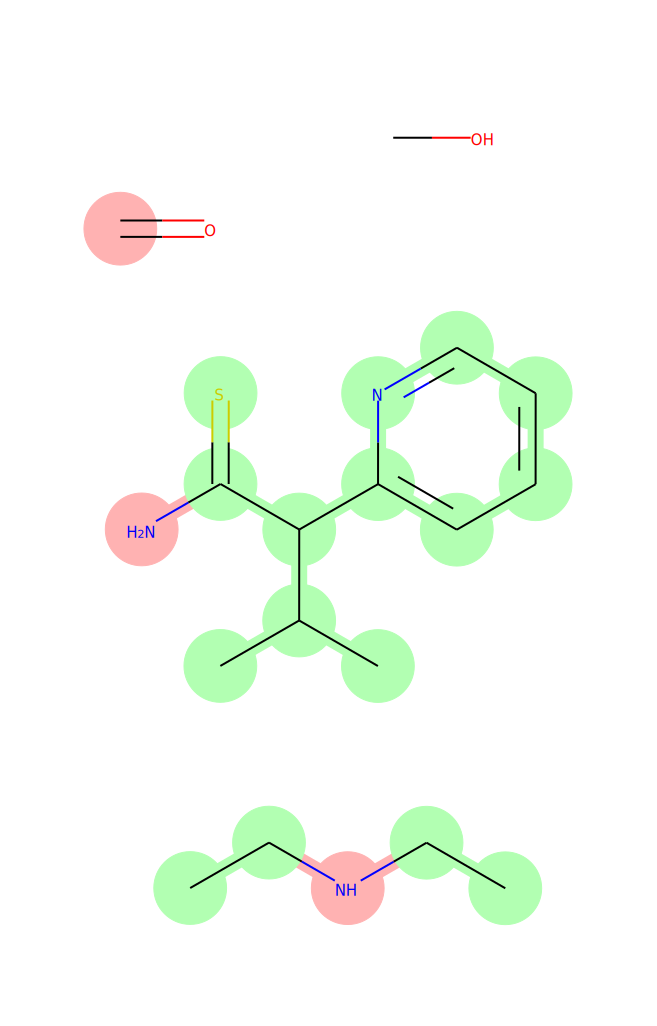

In [14]:
keys = list(test_dataset.keys())
idx = 4
data = test_dataset[keys[idx]]
r_mol, p_mol = get_react_prouct(data['smarts'])
rdDepictor.Compute2DCoords(r_mol)
target_reactants = data['target_main_product'] + data['target_center']
target_reactants[target_reactants == -1] = 0
r = get_molecule_svg(r_mol, target=target_reactants, target_type='GT',
                         gt_colors={1: (0.7, 1, 0.7), 2: (1, 0.7, 0.7)}, dpa=100)
SVG(r)

In [17]:
n_atoms = len(data['target_main_product'])
mp = predictions[0]['predicted'][idx].astype(float)[:n_atoms]
# c = predictions[1]['predicted'][idx].astype(float)[:n_atoms]
# c[data['target_center'] < 0] = 0
# tc = predictions[1]['target'][idx].astype(float)[:n_atoms]

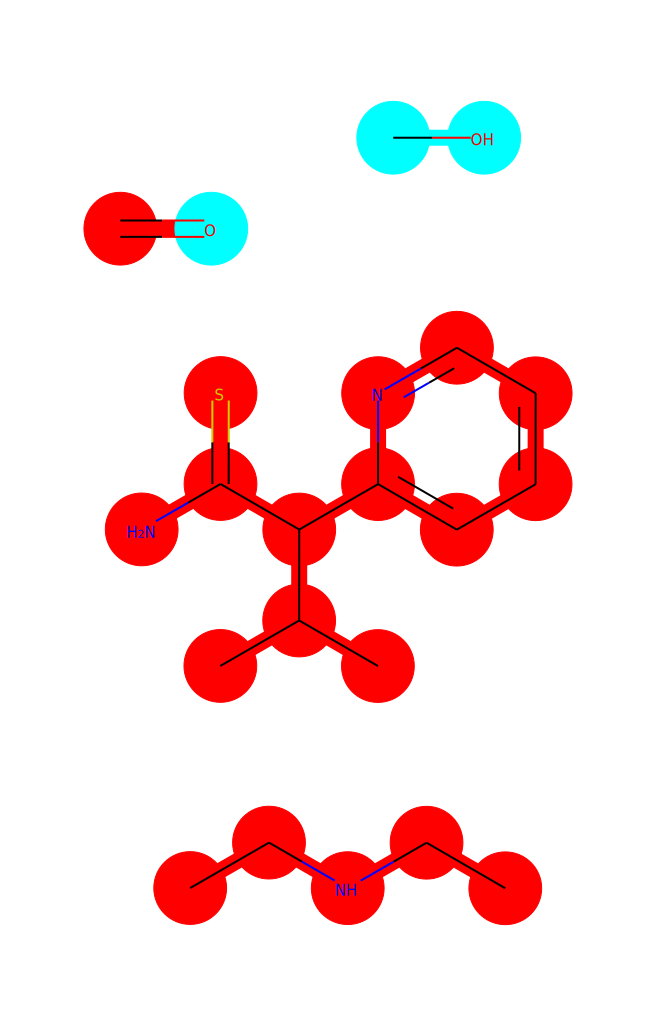

In [20]:
r = get_molecule_svg(r_mol, target=mp, dpa=100)
SVG(r)

In [ ]:
r = get_molecule_png(r_mol, target=c, dpa=100)
SVG(r)